In [27]:
import pandas as pd

df_openCode = pd.read_csv('/content/OpenCodedComments.csv', na_filter=False)
df_ZSclassifier = pd.read_csv('/content/delhi_air_pollution_sentiment_ZS.csv', na_filter=False)

# Stripping whitespace
df_openCode.columns = df_openCode.columns.str.strip()
df_ZSclassifier.columns = df_ZSclassifier.columns.str.strip()

# Merging Open Coded and Zero-shot classifier into one dataframe
df_merged = df_openCode.merge(df_ZSclassifier, on='Comment', how='left',
                              suffixes=('_openCode', '_classifier'))

# Removing duplicates
df_merged = df_merged.drop_duplicates(subset='Comment')

df_merged['Factor_openCode'] = df_merged['Factor_openCode'].str.strip().str.lower()
df_merged['Factor_classifier'] = df_merged['Factor_classifier'].str.strip().str.lower()
df_merged['Sentiment_openCode'] = df_merged['Sentiment_openCode'].str.strip().str.lower()
df_merged['Sentiment_classifier'] = df_merged['Sentiment_classifier'].str.strip().str.lower()

# Normalize factors
def normalize(factors):
    if pd.isna(factors) or factors == '':
        return []
    normalizedFactor = [factor.strip() for factor in factors.split('/')]
    return normalizedFactor

# Apply normalization to Factor_openCode
df_merged['Factor_openCode'] = df_merged['Factor_openCode'].apply(normalize)


# Function to check if any factor from classifier matches any factor from open coding
def agreement(row):
    factors_openCode = row['Factor_openCode']
    factor_classifier = row['Factor_classifier']
    if isinstance(factors_openCode, list):
        return any(factor_classifier == factor for factor in factors_openCode)
    return False

# Check agreement factors and sentiment
df_merged['Factor_agreement'] = df_merged.apply(agreement, axis=1)
df_merged['Sentiment_agreement'] = df_merged['Sentiment_openCode'] == df_merged['Sentiment_classifier']


print("Merged DataFrame with Agreement:")
print(df_merged[['Comment', 'Factor_openCode', 'Factor_classifier', 'Factor_agreement',
                  'Sentiment_openCode', 'Sentiment_classifier', 'Sentiment_agreement']].head())

# Calculate agreement percentage for factore and sentiments
factor_ap = df_merged['Factor_agreement'].mean() * 100
sentiment_ap = df_merged['Sentiment_agreement'].mean() * 100

print(f"\nFactor Agreement Percentage: {factor_ap :.2f}%")
print(f"Sentiment Agreement Percentage: {sentiment_ap :.2f}%")

Merged DataFrame with Agreement:
                                             Comment  \
0  u u evil nasty cm god watching u wrong u peopl...   
1  bjp spoke person child news channel considerin...   
2  delhi issue many state also dealing high pollu...   
3  delhi pollution due physic phenomenon atmosphe...   
4                dewali mein cracker yahe jalate hai   

            Factor_openCode       Factor_classifier  Factor_agreement  \
0              [government]              population             False   
1              [government]                    fire             False   
2              [government]              government              True   
3  [atmospheric conditions]  atmospheric conditions              True   
4            [firecrackers]            firecrackers              True   

  Sentiment_openCode Sentiment_classifier  Sentiment_agreement  
0           negative             negative                 True  
1           negative             negative                 Tru

In [15]:
output_file_path = '/content/merged_data.csv'
df_merged.to_csv(output_file_path, index=False)


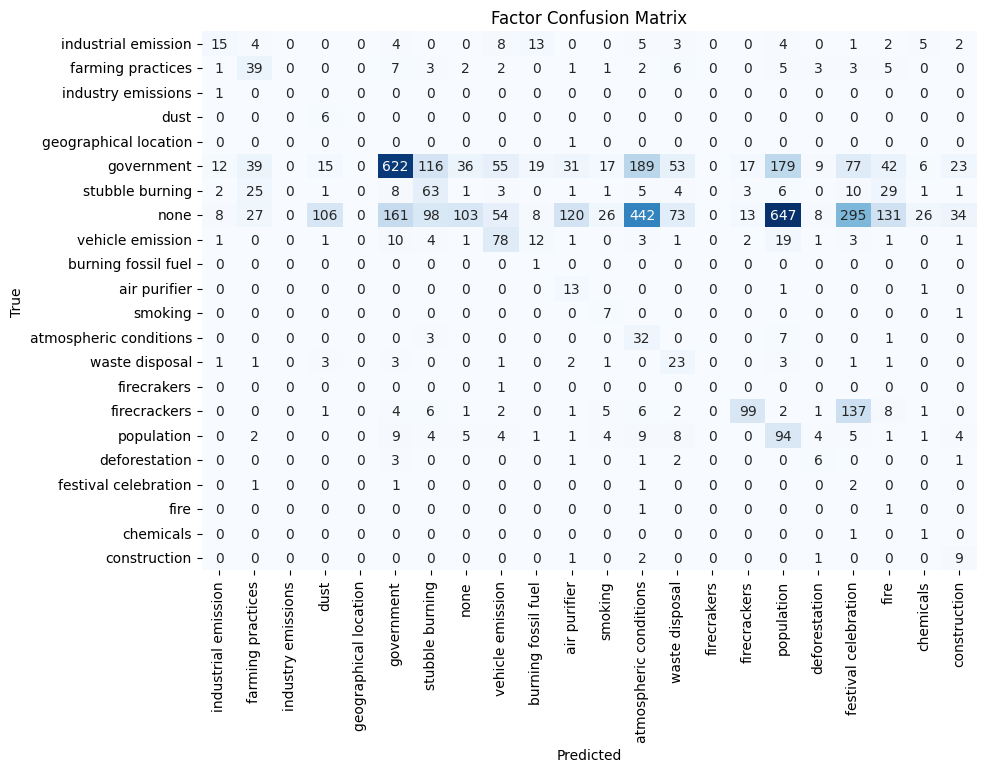

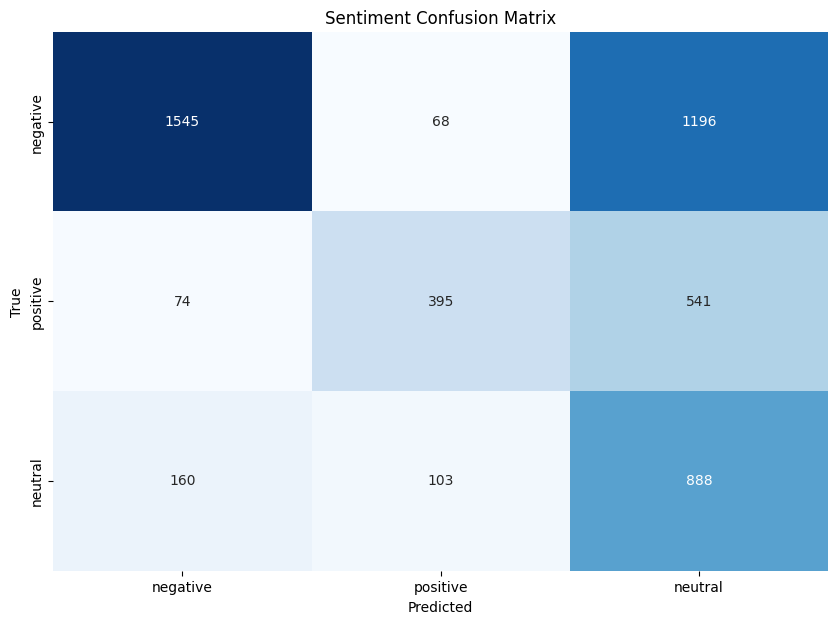

In [26]:
# Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, title='Confusion Matrix', labels = None):
    cm = confusion_matrix(y_true, y_pred, labels = labels)
    plt.figure(figsize = (10, 7))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False,
                xticklabels = labels, yticklabels = labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Factor Confusion Matrix
y_true = df_merged['Factor_openCode'].apply(lambda x: x[0] if isinstance(x, list) and x else np.nan).dropna().tolist()
y_pred = df_merged['Factor_classifier'].dropna().tolist()
min_length = min(len(y_true), len(y_pred))
y_true = y_true[ : min_length]
y_pred = y_pred[ : min_length]
labels_factors = list(set(y_true + y_pred))
plot_cm(y_true, y_pred, labels = labels_factors, title='Factor Confusion Matrix')

# Sentiment Confusion Matrix
y_true_Sentiments = df_merged['Sentiment_openCode'].dropna().tolist()
y_pred_Sentiments = df_merged['Sentiment_classifier'].dropna().tolist()
min_length_sentiments = min(len(y_true_Sentiments), len(y_pred_Sentiments))
y_true_Sentiments = y_true_Sentiments[ : min_length_sentiments]
y_pred_Sentiments = y_pred_Sentiments[ : min_length_sentiments]
labels_sentiments = list(set(y_true_Sentiments + y_pred_Sentiments))
plot_cm(y_true_Sentiments, y_pred_Sentiments, labels = labels_sentiments, title = 'Sentiment Confusion Matrix')


In [24]:
# Calculating Performance Metrics
print("Factor Agreement Counts:")
print(df_merged['Factor_agreement'].value_counts())

print("Sentiment Agreement Counts:")
print(df_merged['Sentiment_agreement'].value_counts())

# Calculate metrics for factor classification
tp = df_merged['Factor_agreement'].sum()
fp = ((df_merged['Factor_classifier'].notna()) & (~df_merged['Factor_agreement'])).sum()
fn = ((df_merged['Factor_openCode'].apply(bool)) & (~df_merged['Factor_agreement'])).sum()
precision_factor = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_factor = tp / (tp + fn) if (tp + fn) > 0 else 0
f1score_factor = 2 * (precision_factor * recall_factor) / (precision_factor + recall_factor) if (precision_factor + recall_factor) > 0 else 0

# Calculate metrics for sentiment classification
tp_sentiment = df_merged['Sentiment_agreement'].sum()
fp_sentiment = ((df_merged['Sentiment_classifier'].notna()) & (~df_merged['Sentiment_agreement'])).sum()
fn_sentiment = ((df_merged['Sentiment_openCode'].apply(bool)) & (~df_merged['Sentiment_agreement'])).sum()
precision_sentiment = tp_sentiment / (tp_sentiment + fp_sentiment) if (tp_sentiment + fp_sentiment) > 0 else 0
recall_sentiment = tp_sentiment / (tp_sentiment + fn_sentiment) if (tp_sentiment + fn_sentiment) > 0 else 0
f1score_sentiment = 2 * (precision_sentiment * recall_sentiment) / (precision_sentiment + recall_sentiment) if (precision_sentiment + recall_sentiment) > 0 else 0

# Display performance metrics
print(f"\nFactor Classification: Precision = {precision_factor:.2f}, Recall = {recall_factor:.2f}, F1 Score = {f1score_factor:.2f}")
print(f"Sentiment Classification: Precision = {precision_sentiment:.2f}, Recall = {recall_sentiment:.2f}, F1 Score = {f1score_sentiment:.2f}")


Factor Agreement Counts:
Factor_agreement
False    3629
True     1341
Name: count, dtype: int64
Sentiment Agreement Counts:
Sentiment_agreement
True     2828
False    2142
Name: count, dtype: int64

Factor Classification: Precision = 0.27, Recall = 0.27, F1 Score = 0.27
Sentiment Classification: Precision = 0.57, Recall = 0.57, F1 Score = 0.57
